# Medical Segmentation Notebook Study

Note: if running in Google Colab, make sure you select T4 as the GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# get current directory
import os
HOME = os.getcwd()


In [2]:
DICOM_PATH = f"{HOME}/data/test_data_dicom"
DATA_PATH = f"/Volumes/Untitled/Totalsegmentator_dataset_v201"
PREDICTIONS_PATH = f"{DATA_PATH}/Predictions"

import os
os.chdir(HOME)

In [5]:
# check python version
import sys
sys.version

'3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]'

In [6]:
TOTAL_SEGMENTATOR = { "name" : "Total Segmentator", "setup" : True }
SAM =  { "name" : "SAM", "setup" : False }

In [7]:

if TOTAL_SEGMENTATOR["setup"]:
  !pip install git+https://github.com/wasserth/TotalSegmentator.git
  !pip install pyvista
  !pip install xmltodict
  !pip install --upgrade acvl_utils==0.2

else:
  print("SAM already installed")


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/wasserth/TotalSegmentator.git to /private/var/folders/yq/4pfbmfps6js_sssz45565g49twkssf/T/pip-req-build-9m1w_4ng
  Running command git clone --filter=blob:none --quiet https://github.com/wasserth/TotalSegmentator.git /private/var/folders/yq/4pfbmfps6js_sssz45565g49twkssf/T/pip-req-build-9m1w_4ng
  Resolved https://github.com/wasserth/TotalSegmentator.git to commit ff50878153342c7b4cb8ae466f7d98aadde4797d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

import imageio.v2 as imageio
import tempfile
import shutil

from IPython.display import Image, HTML

import matplotlib.pyplot as plt
from skimage import measure
import pyvista as pv

from skimage import measure
import plotly.graph_objects as go

import pydicom
import matplotlib.pyplot as plt


def load_ct_scan(file_path):

    if not file_path:
        print("No .nii.gz file found in the folder.")
        return
    # Load the CT scan file
    ct_scan = nib.load(file_path)

    # Get the image data as a NumPy array
    ct_data = ct_scan.get_fdata()

    # Check if data is 3D
    if len(ct_data.shape) != 3:
        print("Expected a 3D CT scan, but got a different shape.")
        return

    # normalize the data
    ct_data = (ct_data - ct_data.min()) / (ct_data.max() - ct_data.min())

    return ct_data

def generate_gif(file_path, output_filepath = "./ct.gif"):

    # Load the CT scan file using nibabel
    ct_data = load_ct_scan(file_path)

    filename = os.path.splitext(os.path.basename(file_path))[0]

    # Normalize the CT scan data for visualization
    ct_data_normalized = (ct_data - ct_data.min()) / (ct_data.max() - ct_data.min()) * 255
    ct_data_normalized = ct_data_normalized.astype(np.uint8)

    # Define the output GIF path
    output_gif_path = os.path.join("gifs", output_filepath)

    # Create a temporary directory for storing images
    temp_dir = tempfile.mkdtemp()

    # Create a GIF animation
    images = []
    for i in range(ct_data_normalized.shape[2]):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(ct_data_normalized[:, :, i], cmap="gray")
        ax.axis('off')
        plt.title(f"Slice {i + 1} of {ct_data_normalized.shape[2]}")

        # Save image to an in-memory file object
        plt.tight_layout()
        image_file = os.path.join(temp_dir, f"{filename}_slice_{i}.png")
        plt.savefig(image_file)
        plt.close()

        # Append image to the images list for GIF creation
        images.append(imageio.imread(image_file))

    # Create the GIF
    imageio.mimsave(output_gif_path, images, duration=0.1)

    # Remove the temporary directory and its contents after GIF creation
    shutil.rmtree(temp_dir)

    #print(f"GIF saved at: {output_gif_path}")
    return output_gif_path


def show_gif(file_path, width=500, height=500):
    return Image(filename=file_path, width=width, height=height)


# Function to load and display a DICOM file
def show_dicom_image(file_path):
    # Load the DICOM file
    dicom_image = pydicom.dcmread(file_path)

    # Get the pixel array from the DICOM file
    pixel_array = dicom_image.pixel_array

    # Plot the image using matplotlib
    plt.imshow(pixel_array, cmap=plt.cm.gray)
    plt.axis('off')  # Turn off axis labels
    plt.title(f"{os.path.basename(file_path)}")
    plt.show()

# Function to iterate through all .dcm files in a directory
def visualize_dicom_files(directory_path):
    # List all files in the directory
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".dcm"):
                file_path = os.path.join(root, file)
                show_dicom_image(file_path)




import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Function to load and visualize all slices of a NIfTI (.nii.gz) file
def show_nii_slices(file_path, n_cols=5):
    # Load the NIfTI file
    img = nib.load(file_path)

    # Get the data as a numpy array
    img_data = img.get_fdata()

    # Number of slices in the z-axis
    num_slices = img_data.shape[2]

    # Calculate the number of rows needed
    n_rows = int(np.ceil(num_slices / n_cols))

    # Create subplots with the calculated rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    fig.subplots_adjust(hspace=0.3)

    # Plot each slice in the appropriate subplot
    for i in range(num_slices):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        ax.imshow(img_data[:, :, i], cmap='gray')
        ax.set_title(f'Slice {i+1}/{num_slices}')
        ax.axis('off')  # Hide the axes

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    plt.show()

# Function to load and display a specific slice from a .nii.gz file
def load_nii_slice(nii_file_path, slice_index):
    # Load the NIfTI file
    nii_image = nib.load(nii_file_path)

    # Get the data as a numpy array
    img_data = nii_image.get_fdata()

    # Check if slice_index is within the range of available slices
    if slice_index < 1 or slice_index > img_data.shape[2]:
        raise ValueError(f"Slice index {slice_index} is out of range for this image with {img_data.shape[2]} slices.")

    # Extract the specified slice (note: subtract 1 because slice_index is 1-based)
    slice_data = img_data[:, :, slice_index - 1]
    return slice_data

# Function to load and display the 350th DICOM file
def load_dicom_slice(dicom_directory, slice_index):
    # List all files in the directory
    dicom_files = [os.path.join(dicom_directory, f) for f in os.listdir(dicom_directory) if f.endswith('.dcm')]
    dicom_files.sort()  # Sort to ensure consistent ordering

    # Load the DICOM file corresponding to the slice index (350th)
    dicom_file = dicom_files[slice_index - 1]
    dicom_image = pydicom.dcmread(dicom_file)

    # Get the pixel array from the DICOM file
    pixel_array = dicom_image.pixel_array
    return pixel_array

# Function to load the 350th slice from a NIfTI file (segmentation mask)
def load_nii_segmentation(nii_file_path, slice_index):
    # Load the NIfTI file
    img = nib.load(nii_file_path)

    # Get the data as a numpy array
    img_data = img.get_fdata()

    # Return the slice corresponding to the slice index (350th)
    seg_slice = img_data[:, :, slice_index - 1]
    return seg_slice

# Function to overlap DICOM and segmentation mask
def overlay_images(dicom_slice, seg_slice):
    # Normalize both images to [0, 1] for visualization purposes
    dicom_norm = (dicom_slice - np.min(dicom_slice)) / (np.max(dicom_slice) - np.min(dicom_slice))
    seg_mask = seg_slice.astype(bool)  # Convert segmentation to boolean mask

    # Create an RGB image for overlaying: DICOM as grayscale, segmentation as red
    overlay = np.zeros((dicom_norm.shape[0], dicom_norm.shape[1], 3))
    overlay[:, :, 0] = dicom_norm  # Red channel for the segmentation
    overlay[:, :, 1] = dicom_norm  # Green channel for the DICOM
    overlay[:, :, 2] = dicom_norm  # Blue channel for the DICOM
    overlay[seg_mask, 0] = 1  # Make segmentation region red

    return overlay

# Function to visualize DICOM, segmentation, and overlap side by side
def visualize_side_by_side(dicom_slice, seg_slice, overlay, isPrediction = False):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display DICOM slice
    axes[0].imshow(dicom_slice, cmap='gray')
    axes[0].set_title('Image Slice')
    axes[0].axis('off')

    # Display segmentation slice
    axes[1].imshow(seg_slice, cmap='gray')
    if isPrediction:
        axes[1].set_title('Predicted Segmented Slice')
    else:
        axes[1].set_title('Groundtruth Segmented Slice')
    axes[1].axis('off')

    # Display overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.show()


def generate_3d_reconstruction(file_path, id = "ID0"):
    
    # Load the segmented mask file
    ct_data = load_ct_scan(file_path)

    filename = os.path.basename(file_path)
    
    # Extract the 3D surface using the marching cubes algorithm
    vertices, faces, _, _ = measure.marching_cubes(ct_data, level=0.7)

    # Reformat the faces array to match the expected format for PyVista
    # PyVista expects a flat array where each face is prefixed by the number of points (e.g., 3 for triangles)
    faces_formatted = np.hstack([[3] + list(face) for face in faces])

    # Create a PyVista mesh for visualization
    mesh = pv.PolyData(vertices, faces_formatted)
    
    output_path = os.path.join(HOME, "mesh", id)
    
    # create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    output_path = os.path.join(output_path, filename + ".vtk")
    print(f"Saving mesh to {output_path}")
    
    mesh.save(output_path)

    return mesh


def visualize_mesh(mesh, file_path, id, smoothing_iter = 50, relaxation_factor = 0.1, mesh_color = '#FFCC99', opacity = 0.7, background_color = "black" ):
    
    filename = os.path.basename(file_path)
        
    mesh_smooth = mesh.smooth(n_iter=smoothing_iter, relaxation_factor=relaxation_factor)

    # Set up the PyVista plotter
    plotter = pv.Plotter()
    plotter.add_mesh(mesh_smooth, 
                        color=mesh_color, 
                        show_edges=False, 
                        opacity=opacity,
                        smooth_shading=True,
                        ambient=0,
                        )
    plotter.add_axes()
    plotter.set_background(background_color)

    output_path = os.path.join(HOME, "3d_reconstruction", id)
    
    # create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    output_path = os.path.join(output_path, filename + ".html")
    print(f"Saving mesh to {output_path}")

    # Save the plot as an interactive HTML file using 'pythreejs' backend
    plotter.export_html(output_path, backend='pythreejs')
    html_content = open(output_path, 'r').read()

    return html_content



In [20]:
import numpy as np
from sklearn.metrics import jaccard_score

def dice_coefficient(pred, gt):
    """Calculate Dice Similarity Coefficient"""
    intersection = np.sum((pred > 0) * (gt > 0))
    return 2.0 * intersection / (np.sum(pred > 0) + np.sum(gt > 0))

def iou(pred, gt):
    """Calculate Intersection over Union (IoU)"""
    intersection = np.sum((pred > 0) * (gt > 0))
    union = np.sum((pred > 0) + (gt > 0))
    return intersection / union

def mean_squared_error(pred, gt):
    """Calculate Mean Squared Error (MSE)"""
    return np.mean((pred - gt) ** 2)

def pixel_accuracy(pred, gt):
    """Calculate Pixel-wise Accuracy"""
    return np.sum(pred == gt) / pred.size




## Dataset Visualisation

In [32]:
dataset = "Totalsegmentator_dataset_v201"
patient_ID = "s0001"
organ = "colon"

path_to_ctscan = os.path.join(patient_ID, "ct.nii.gz")
path_to_mask = os.path.join(patient_ID, "segmentations", f"{organ}.nii.gz")

ct_filepath = os.path.join(DATA_PATH, path_to_ctscan)
ct_output_filepath = os.path.join(HOME, "gifs",  f"{patient_ID}_ct.gif" )

mask_filepath = os.path.join(DATA_PATH, path_to_mask)
output_mask_filepath = os.path.join(HOME,  "gifs",  f"{patient_ID}_{organ}.gif")

#show_nii_slices(nii_file_path)
ct_scan_gif = generate_gif(ct_filepath, output_filepath=ct_output_filepath)
ct_scan_segm_gif = generate_gif(mask_filepath, output_filepath=output_mask_filepath)

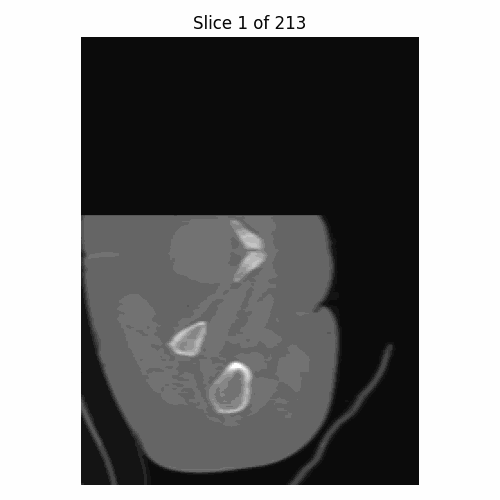

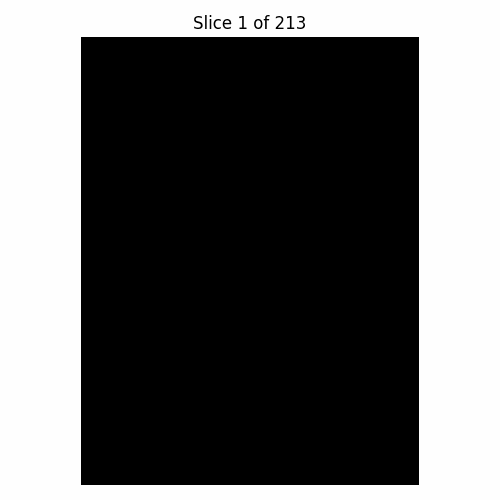

In [27]:
WIDTH = 400
HEIGHT = 300

[display(Image(filename=ct_scan_gif, width=WIDTH, height=HEIGHT)),
 display(Image(filename=ct_scan_segm_gif, width=WIDTH, height=HEIGHT))];

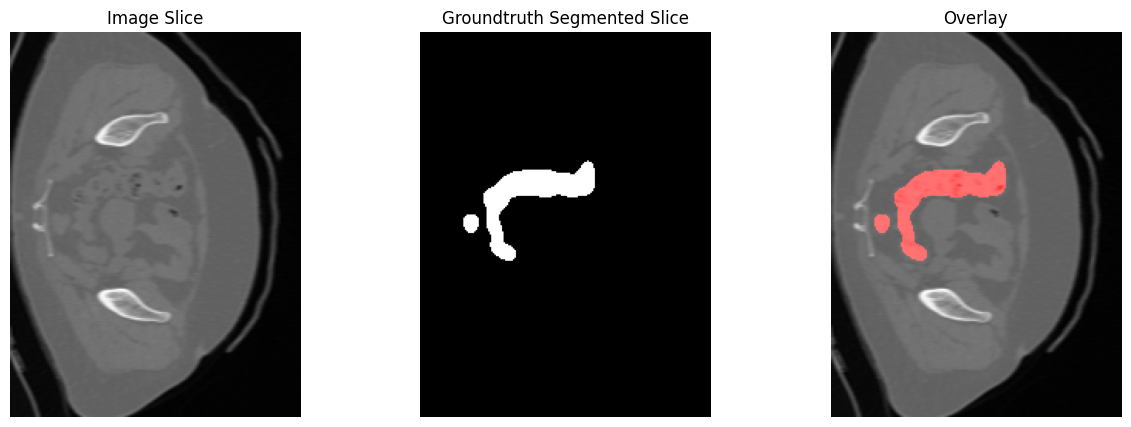

In [28]:

INDEX = 50

dicom_slice = load_nii_slice(ct_filepath, INDEX)
seg_slice = load_nii_segmentation(mask_filepath, INDEX)

# Create the overlay image
overlay_image = overlay_images(dicom_slice, seg_slice)

# Visualize all three images side by side
visualize_side_by_side(dicom_slice, seg_slice, overlay_image)


## Total Segmentator Example

In [29]:
import nibabel as nib
import os
from totalsegmentator.python_api import totalsegmentator


In [33]:

dataset_folder = "Totalsegmentator_dataset_v201"
patient_ID = "s0001"

input_image_path =  os.path.join(DATA_PATH,  patient_ID, "ct.nii.gz" )
output_dir = os.path.join(PREDICTIONS_PATH, patient_ID)

print("Input file path: ", input_image_path)
print("Output directory: ", output_dir)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the input image (optional, for checking dimensions)
input_image = nib.load(input_image_path)
image_data = input_image.get_fdata()  # Get the image data as a NumPy array
print("Input Image Shape:", input_image.shape)


In [34]:
# Define task and device
task = "total"       # Full-body segmentation
device = "cpu"       # Set to "mps" if using a mac with an M1 > chip, "gpu" if available, otherwise "cpu"

# Run the segmentation
try:
  seg_img, stats = totalsegmentator(input=input_image_path,
                                    output=output_dir,
                                    task=task,
                                    device=device,
                                    statistics=False)
except TypeError as e:
  print(f"An error occurred: {e}")

print("Segmentation Complete.")


100%|██████████| 12/12 [01:18<00:00,  6.57s/it]


  0%|          | 0/117 [00:00<?, ?it/s]

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt


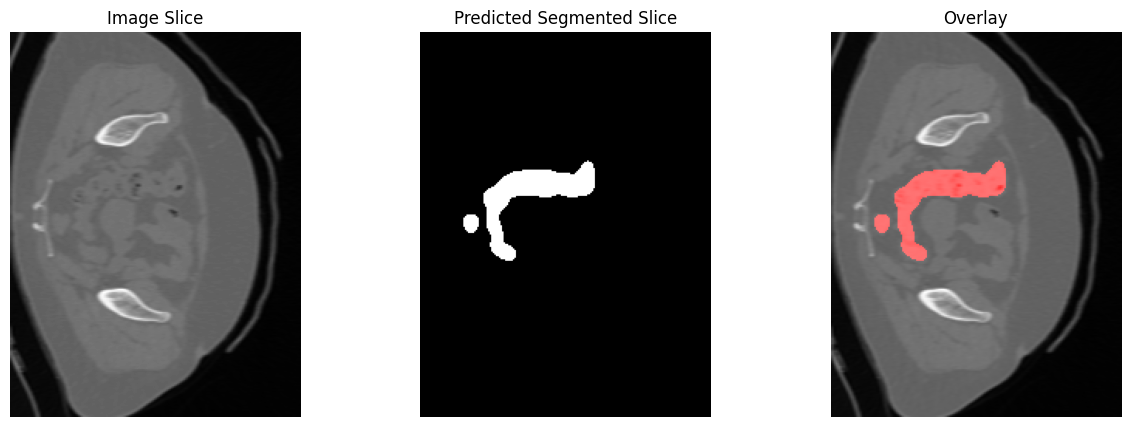

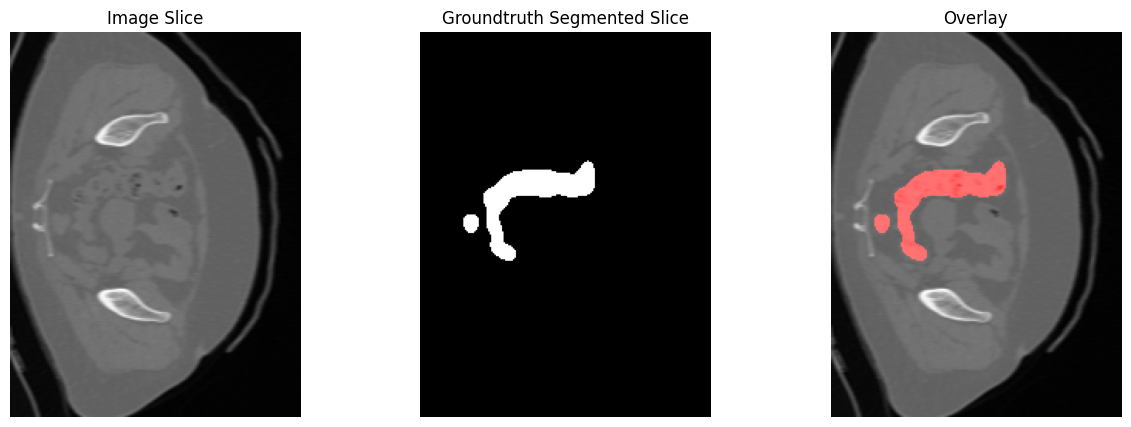

In [43]:
INDEX = 50

predicted_mask_filepath = os.path.join(output_dir, "colon.nii.gz" )
PR_seg_slice = load_nii_segmentation(mask_filepath, INDEX)
print("Predicted Mask Path: ", predicted_mask_filepath)

groundtruth_mask_path = os.path.join(DATA_PATH,patient_ID, "segmentations", f"{organ}.nii.gz")
GT_seg_slice = load_nii_segmentation(groundtruth_mask_path, INDEX)
print("GroundTruth Mask Path: ", groundtruth_mask_path)

input_slice = load_nii_slice(input_image_path, INDEX)

# Create the overlay image
PR_overlay_image = overlay_images(input_slice, PR_seg_slice)
GT_overlay_image = overlay_images(input_slice, GT_seg_slice)

# Visualize all three images side by side
visualize_side_by_side(input_slice, PR_seg_slice, PR_overlay_image, isPrediction=True)
visualize_side_by_side(input_slice, GT_seg_slice, GT_overlay_image, isPrediction=False)

In [46]:
# Calculate metrics
print("Dice Similarity Coefficient:",  np.round(dice_coefficient(PR_seg_slice, GT_seg_slice), 4))
print("Intersection over Union (IoU):", np.round(iou(PR_seg_slice, GT_seg_slice), 4))
print("Mean Squared Error (MSE):", np.round(mean_squared_error(PR_seg_slice, GT_seg_slice), 4))
print("Pixel Accuracy:", np.round(pixel_accuracy(PR_seg_slice, GT_seg_slice), 4))


In [49]:
np.round(mean_squared_error(PR_seg_slice, GT_seg_slice), 4)

0.0

In [38]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

import imageio.v2 as imageio
import tempfile
import shutil

from IPython.display import Image, HTML

import matplotlib.pyplot as plt
from skimage import measure
import pyvista as pv

from skimage import measure
import plotly.graph_objects as go

import pydicom
import matplotlib.pyplot as plt

In [51]:
# Adjusted code without backend argument
mesh = generate_3d_reconstruction(groundtruth_mask_path, id=patient_ID);

# Displaying the mesh in HTML format
display(HTML(visualize_mesh(mesh, groundtruth_mask_path, id=patient_ID, opacity=1)));


In [40]:
# Adjusted code without backend argument
mesh = generate_3d_reconstruction(predicted_mask_filepath, id=patient_ID)

# Displaying the mesh in HTML format
display(HTML(visualize_mesh(mesh, predicted_mask_filepath, id=patient_ID, opacity=1)))
